In [126]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
import statsmodels.api as sm
import matplotlib.pyplot as plt
import graphviz

In [25]:
dataset = pd.read_csv("Carseats.csv", sep = ',')
dataset
dataset = dataset.drop(dataset.columns[0], axis=1)

In [26]:
dataset.describe

<bound method NDFrame.describe of      Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0     9.50        138      73           11         276    120       Bad   42   
1    11.22        111      48           16         260     83      Good   65   
2    10.06        113      35           10         269     80    Medium   59   
3     7.40        117     100            4         466     97    Medium   55   
4     4.15        141      64            3         340    128       Bad   38   
..     ...        ...     ...          ...         ...    ...       ...  ...   
395  12.57        138     108           17         203    128      Good   33   
396   6.14        139      23            3          37    120    Medium   55   
397   7.41        162      26           12         368    159    Medium   40   
398   5.94        100      79            7         284     95       Bad   50   
399   9.71        134      37            0          27    120      Good   49   

     

In [27]:
dataset['High'] = dataset.Sales.map(lambda x: 1 if x>8 else 0)
dataset.ShelveLoc = pd.factorize(dataset.ShelveLoc)[0]
dataset.Urban = dataset.Urban.map({'No':0, 'Yes':1})
dataset.US = dataset.US.map({'No':0, 'Yes':1})
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
 11  High         400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In [28]:
X = dataset.drop(['Sales', 'High'], axis = 1)
y = dataset.High

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

In [34]:
regr_tree = DecisionTreeRegressor(random_state=0)
regr_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

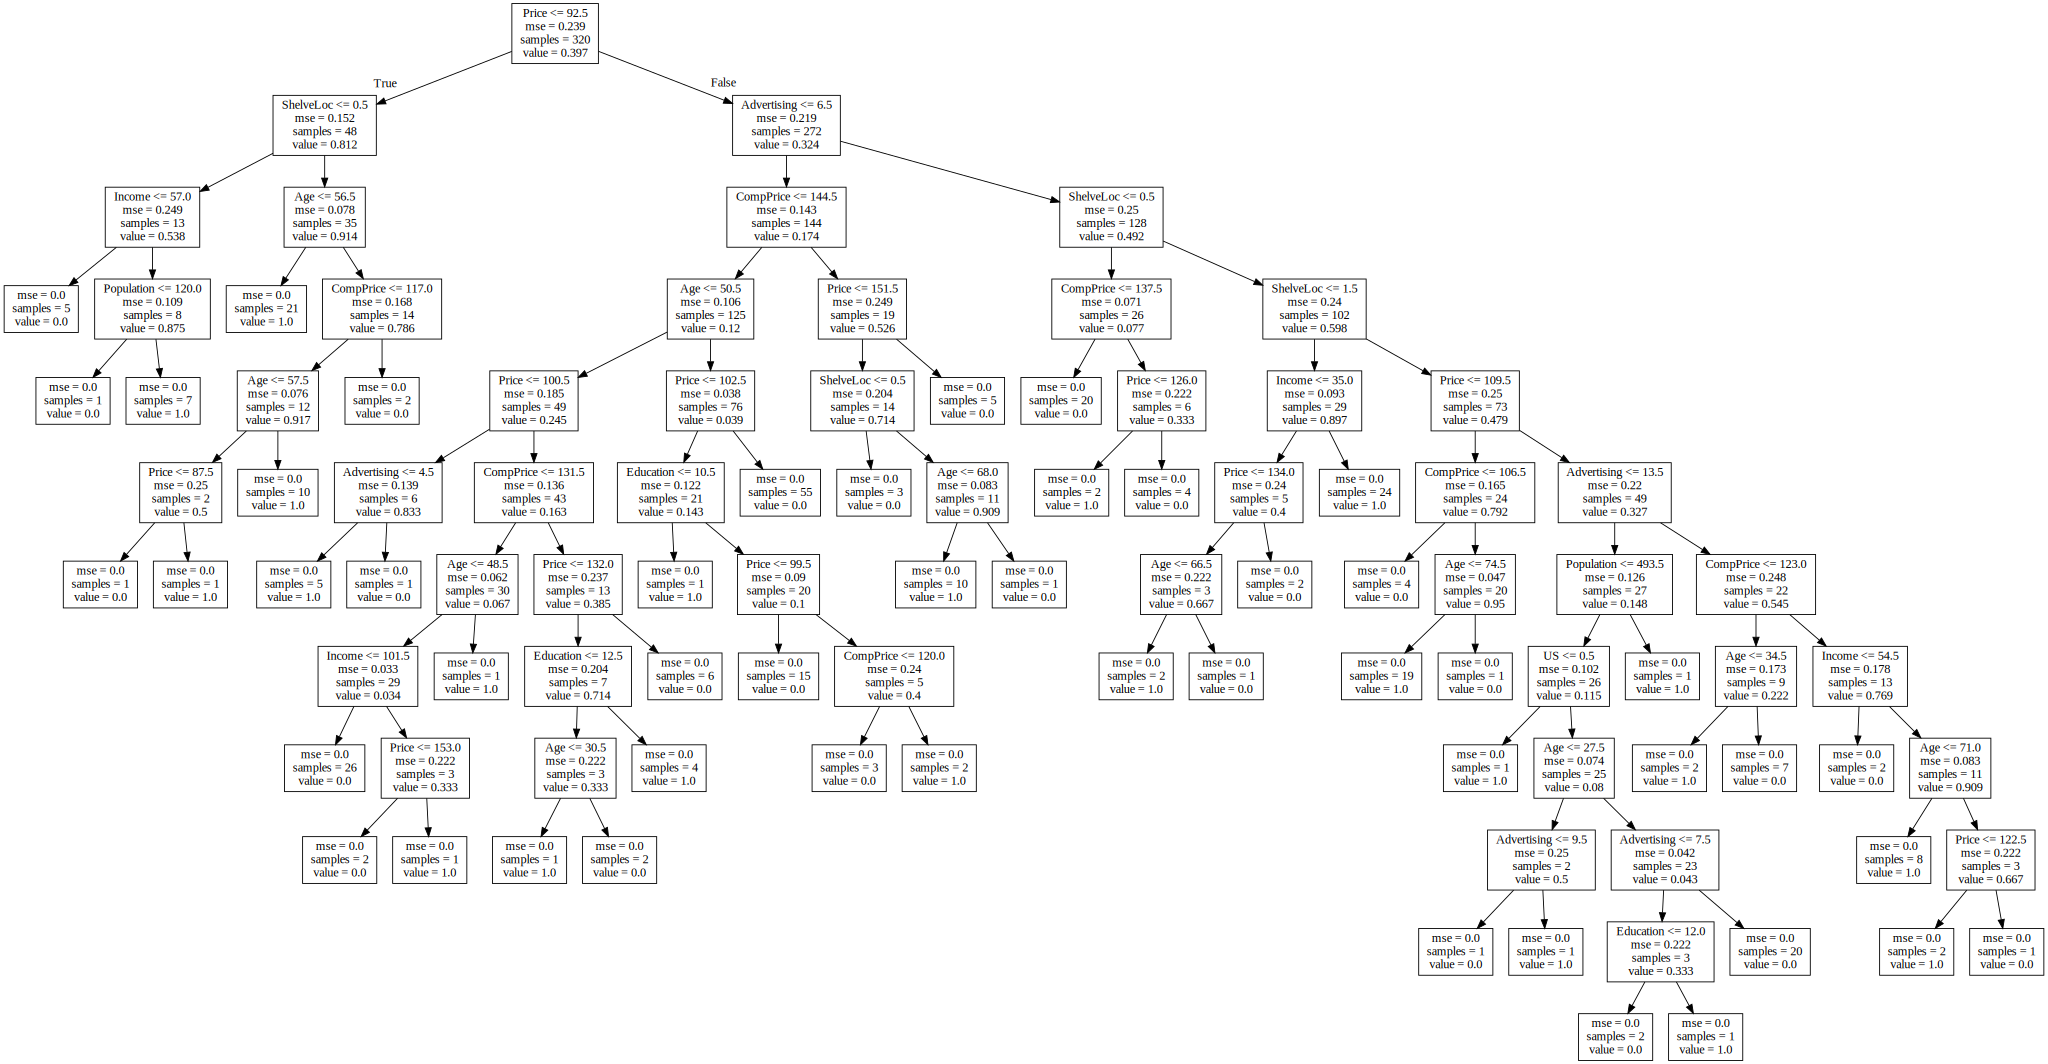

In [35]:
export_graphviz(regr_tree, 
                out_file = "regr_tree.dot", 
                feature_names = X_train.columns)

with open("regr_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

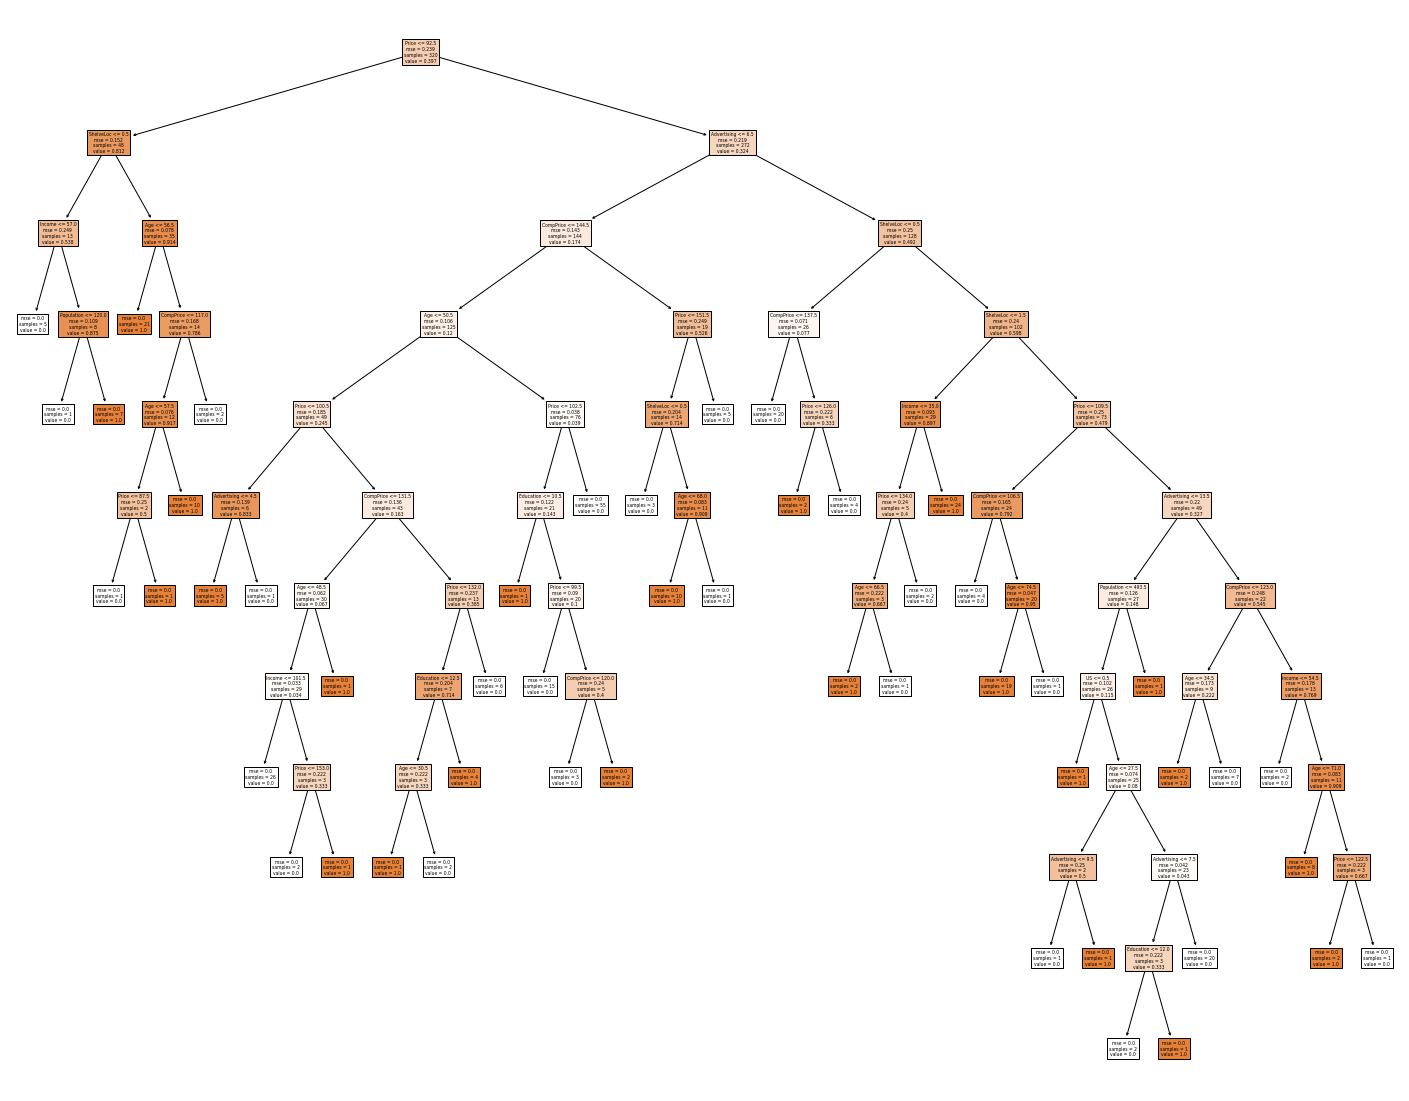

In [36]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr_tree, feature_names=X.columns, filled=True)

0.275

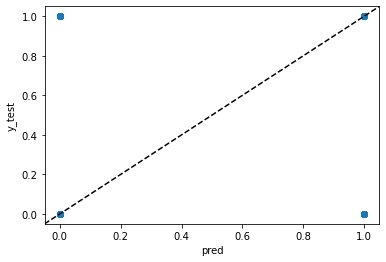

In [39]:
pred = regr_tree.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)

In [105]:
precision = 1 - mean_squared_error(y_test, pred)
precision

0.725

In [94]:
new_tree = DecisionTreeRegressor(random_state=0)
path = new_tree.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00142045, 0.00143229, 0.0014375 , 0.00150862,
        0.001875  , 0.00208333, 0.00225123, 0.00238095, 0.00244907,
        0.00260417, 0.00273437, 0.00281609, 0.00284091, 0.00285342,
        0.00288462, 0.00296875, 0.00400817, 0.00437063, 0.00465517,
        0.00486111, 0.0049728 , 0.00566347, 0.00577288, 0.00597987,
        0.00598086, 0.008509  , 0.00940104, 0.01089167, 0.01128367,
        0.01758258, 0.02149219, 0.03048426]),
 'impurities': array([0.        , 0.00284091, 0.00570549, 0.01145549, 0.01447273,
        0.01822273, 0.02030607, 0.029311  , 0.03169195, 0.0365901 ,
        0.03919427, 0.04192864, 0.04474474, 0.04758564, 0.05329249,
        0.05906172, 0.06203047, 0.07004681, 0.07441743, 0.07907261,
        0.08393372, 0.08890652, 0.10023347, 0.11177923, 0.11775909,
        0.12972082, 0.13822982, 0.14763086, 0.15852253, 0.1698062 ,
        0.18738878, 0.20888097, 0.23936523])}

Text(0, 0.5, 'total impurity of leaves')

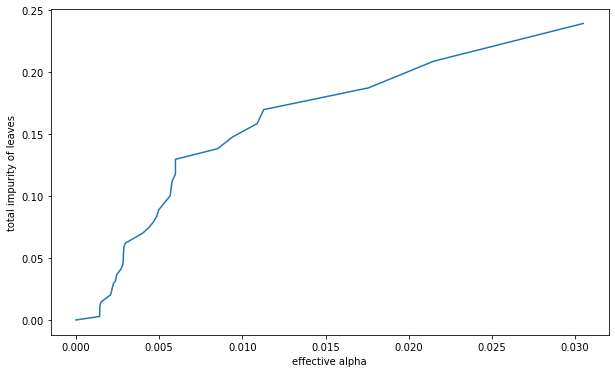

In [95]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [96]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

Text(0, 0.5, 'total depth')

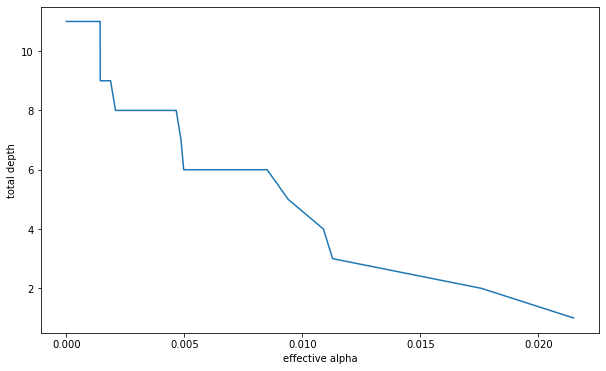

In [97]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")

Text(0, 0.5, 'Accuracy scores')

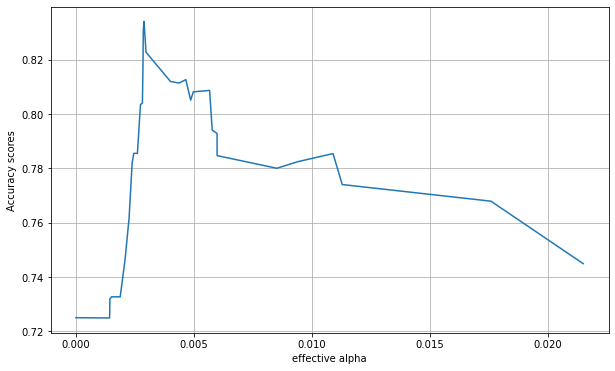

In [107]:
from sklearn.metrics import max_error
acc_scores = [(1 - mean_squared_error(y_test, clf.predict(X_test))) for clf in clfs]

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Accuracy scores")

In [124]:
def run_cross_validation_on_trees(X, y, tree_depths, cv=10, scoring='neg_root_mean_squared_error'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeRegressor(max_depth=depth)
        tree_model.fit(X, y)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=None)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores

In [109]:
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    #ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

In [125]:
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

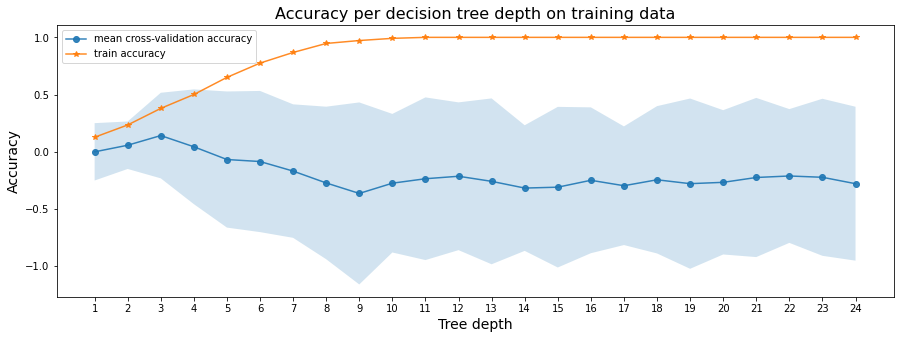

In [84]:
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [127]:
bagged_tree = RandomForestRegressor(max_features = 10, random_state = 0)
bagged_tree.fit(X_train, y_train)

RandomForestRegressor(max_features=10, random_state=0)

0.82789375

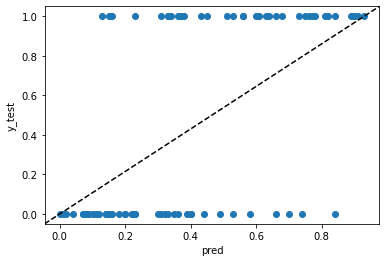

In [130]:
pred = bagged_tree.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_squared_error(y_test, pred)
precision = 1 - mean_squared_error(y_test, pred)
precision

In [132]:
random_forest_tree = RandomForestRegressor(max_features = 8, random_state = 0)

random_forest_tree.fit(X_train, y_train)

pred = random_forest_tree.predict(X_test)
mean_squared_error(y_test, pred)
precision = 1 - mean_squared_error(y_test, pred)
precision

0.839005

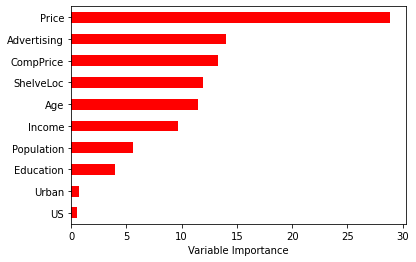

In [134]:
Importance = pd.DataFrame({'Importance':bagged_tree.feature_importances_*100}, 
                          index = X.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

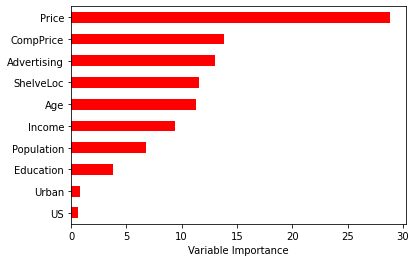

In [133]:
Importance = pd.DataFrame({'Importance':random_forest_tree.feature_importances_*100}, 
                          index = X.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [ ]:
def m_importance(n):
    model = RandomForestRegressor(max_features = n, random_state = 0)
    model.fit(X_train, y_train)
    pred = random_forest_tree.predict(X_test)
    mean_squared_error(y_test, pred)